# Course Project

### Solution by: *Latifa Al-Naimi* 

## Description
The project I've chosen to model through a supervised machine learning project is the prediction of tweets representing sentiments that were supportive or condemning towards public displays of feminism or women's rights activism. I focus on tweets that were responses to a woman declaring her liberation through twitter when she sought asylum after leaving an oppressive environment. She publicly disclosed her name and picture, which garnered wide array of responses. This is my training data. I use this data to build a model to classify supportive and condemning sentiments.

### Motivation
My long term goal is to understand in what ways anti-feminist sentiments manifest in the Middle East, in both English and Arabic. For the scope of this project, my goal was to build a simple predictor of anti-feminist sentiment by feature extraction. In the future, I aim to identify the most important features and test them on a variety of datasets from other contexts.

## 1. Data collection

### 1.1 Tweepy setup
I installed tweepy onto the conda environment created at the beginning of class: `conda install tweepy`. This is required to be able to use Twitter API v2 via Python. The `btoken` variable below represents the "bearer token" --a secret key that ties my personal application to a tweepy client. It has been removed prior to submission of this notebook.

In [87]:
import tweepy
import time
import re
import string
import pandas as pd
import altair as alt
from langdetect import detect

#from twitter_authentication import btoken

In [11]:

# Authenticate this application
btoken = "redacted"
client = tweepy.Client(btoken, wait_on_rate_limit=True)

### 1.2 Obtaining training data
#### Context
The training data I obtained is based on interactions in the time frame of a specific tweet posted by user @Aishalqahtani. The tweet is in Arabic, but in this tweet, Aisha disclosed her name and picture for the first time after years of being anonymous while living in Qatar. She posted this after seeking asylum in the UK and subsequently received a litany of responses in suppport of and criticizing her actions. The code below retrieves  metadata tied to that specific tweet.

In [56]:
origin_id = "1218892822599950343"
initial_data = client.get_tweet(origin_id, tweet_fields=['geo','referenced_tweets'])
print(initial_data)

Response(data=<Tweet id=1218892822599950343 text=سلڤادور هي عائشة القحطاني، قطرية، محبة لوطني، ولكن أمضيت ٢٢ سنة تحت القوانين القامعة للمرأة في قطر، والتي تعطي كل التفويض لذكر العائلة، القوانين التي تدهس على المعنفات وتكرههم على التنازل عن حقوقهم، اقف هنا بعد ان نجيت بذاتي من كل ذلك، لأتحدث عن تجربتي وتجربة غيري من النساء. https://t.co/XT1urKj3jX>, includes={}, errors=[], meta={})


#### Tweepy queries
Using the time frame of the above tweet, I queried all tweets in that time frame that were replies or quote tweets of the user @aishalqahtani and stored the responses in `aisha_tweets`.

In [72]:
# Querying replies and retweets to Aisha's 'tweet of independence'
aisha_tweets = []
for response in tweepy.Paginator(client.search_all_tweets, 
                                 query = 'to:aishalqahtani OR retweets_of:aishalqahtani',
                                 user_fields = ['username', 'name', 'location', 'profile_image_url'],
                                 tweet_fields = ['id','created_at', 'geo', 'public_metrics', 'text'],
                                 expansions = 'author_id',
                                 start_time = '2020-01-19T06:00:00Z',
                                 end_time = '2020-01-30T00:00:00Z',
                              max_results=500):
    time.sleep(1)
    aisha_tweets.append(response)

NameError: name 'client' is not defined

In [71]:
# Example response tweet
aisha_tweets[10].data[2]

NameError: name 'aisha_tweets' is not defined

#### Converting responses to dataframe
Responses returned above are a complex multi-level data structure, so I created a function `to_dataframe()` so that it could be used for converting both training and test responses to data frames. The function body was obtained from this Twitter API v2 tutorial: <https://www.youtube.com/watch?v=rQEsIs9LERM>

In [47]:

def to_dataframe(responses: list): 
    result = []
    user_dict = {}
    # Loop through each response object
    for response in responses:
        # Take all of the users, and put them into a dictionary of dictionaries with the info we want to keep
        for user in response.includes['users']:
            user_dict[user.id] = {'username': user.username, 
                                  'name': user.name,
                                  'profile_image_url': user.profile_image_url,
                                  'location': user.location
                                 }
        for tweet in response.data:
            # For each tweet, find the author's information
            author_info = user_dict[tweet.author_id]
            # Put all of the information we want to keep in a single dictionary for each tweet
            result.append({'author_id': tweet.author_id, 
                           'username': author_info['username'],
                           'name': author_info['name'],
                           'author_location': author_info['location'],
                           'text': tweet.text,
                           'created_at': tweet.created_at,
                           'retweets': tweet.public_metrics['retweet_count'],
                           'replies': tweet.public_metrics['reply_count'],
                           'likes': tweet.public_metrics['like_count'],
                           'quote_count': tweet.public_metrics['quote_count']
                          })

    # Change this list of dictionaries into a dataframe
    df = pd.DataFrame(result)
    return df


In [48]:
aisha_reaction_df = to_dataframe(aisha_tweets)

In [49]:
aisha_reaction_df

,author_id,username,name,author_location,text,created_at,retweets,replies,likes,quote_count
0,1216698138125271041,Genat99952881,Genat,None,RT @sa_vadorr: هناك فتيات يتعرضن للضرب والاضطه...,2020-01-29 23:04:47+00:00,95,0,0,0
1,147036773,ArabianSaluki,Arabian Saluki,"Riyadh, Saudi Arabia",RT @sa_vadorr: طبعا قناة الجزيرة حاليا على وضع...,2020-01-29 22:42:08+00:00,182,0,0,0
2,147036773,ArabianSaluki,Arabian Saluki,"Riyadh, Saudi Arabia",RT @sa_vadorr: يا عيني!، الجديد الان انه عندما...,2020-01-29 22:39:53+00:00,77,0,0,0
3,17024104,innosinz,Nicole Deniese Harris,"Virginia, USA","@sa_vadorr 100% right, I covered not knowing i...",2020-01-29 22:08:39+00:00,0,0,0,0
4,541397323,Critic_man,ناصر,None,RT @sa_vadorr: سلڤادور هي عائشة القحطاني، قطري...,2020-01-29 21:06:45+00:00,1735,0,0,0
...,...,...,...,...,...,...,...,...,...,...
6397,953150634865430528,naah1980,نــاهــد,None,@sa_vadorr ياشماتت ابله طازه فينا 😂😂😂,2020-01-19 13:31:49+00:00,0,0,1,0
6398,2911674320,AlyafieHanan,❄ حنان اليافعي,خارجَ السّرْب,RT @sa_vadorr: جريدة الراية اثارت الرأي العام،...,2020-01-19 13:19:54+00:00,20,0,0,0
6399,1209870499284697088,keyalrumaihi,keyalrumaihi🇶🇦,"Doha, Qatar",@sa_vadorr بعد اتذمون في البلاد ذم ولسانكم طوي...,2020-01-19 11:58:23+00:00,0,0,0,0
6400,1086235403710054400,Ayshalkubaisi1,Ayshalkubaisi_,None,@sa_vadorr عيشي انسانيتچ الغير سوية مع نفسچ لا...,2020-01-19 11:46:27+00:00,0,0,0,0


In [50]:
aisha_reaction_df.to_csv('tweet-data/aisha_interactions.csv')

### 1.3 Obtaining test data
The method used to obtain test data is the same as training data, however, I chose a more recent incident with a different user, @noofalmaadeed, and obtained interactions within a shorter time frame (2-3 weeks).

In [51]:
noof_tweets = []
for response in tweepy.Paginator(client.search_all_tweets, 
                                 query = 'to:noofalmaadeed OR retweets_of:noofalmaadeed',
                                 user_fields = ['username', 'name', 'location', 'profile_image_url'],
                                 tweet_fields = ['id','created_at', 'geo', 'public_metrics', 'text'],
                                 expansions = 'author_id',
                                 start_time = '2021-10-11T00:00:00Z',
                                 end_time = '2021-10-30T00:00:00Z',
                              max_results=500):
    time.sleep(1)
    noof_tweets.append(response)

In [53]:
noof_reaction_df = to_dataframe(noof_tweets)
noof_reaction_df.to_csv('tweet-data/noof_interactions.csv')

## 2. Data cleaning
### 2.1 Removing duplicate retweets
There were several duplicate retweets listed as separate datasets, so I took measures to remove them using the drop_duplicates() function in `pandas`. I did this for both training and test and test CSV files.

* Initial number of training tweets: 6401

* Initial number of test tweets: 637

In [82]:
# Training data
df = pd.read_csv('tweet-data/training_duplicates.csv', 
                usecols=['text']).drop_duplicates(keep=False).reset_index()
df.to_csv('input-csv/train.csv')

In [83]:
# Test data
df = pd.read_csv('tweet-data/test_duplicates.csv', 
                usecols=['text']).drop_duplicates(keep=False).reset_index()
df.to_csv('input-csv/test.csv')

### 2.2 Offline CSV restructuring
When I retrieved the tweets using the twitter API client, I specified several meta data that were interesting to me and seemed like they might be relevant. However, this meta data was removed for this particular project as I am only analyzing the text data in the tweets for the time being. 

Steps taken offline:
* Removed non-text data (e.g. user location, name, etc) as it is irrelevant to this project. 
* Removed the old index column
* Removed header

After steps **2.1** and **2.2**, I ended up with:
* Training tweets: 3243
* Test tweets: 341

## 3. Annotation
For this project, annotation was a requirement for a number of reasons. First, there were no similar datasets that were labeled due to the niche nature of the project. Second, The tweets of interest were both in English and Arabic as both languages are used quite frequently in the geographic region I am studying. But more than that, the Arabic used is not classic Arabic, rather a specific dialect unique to that region, so correct annotations can only be administered by someone who understands them both. The alternative would be to cut out a significant portion of the dataset, but for this study (or an extension of it), both languages need to be taken into account.

### 3.1 Label description
Offline, I added a column for the label in both `training.csv` and `test.csv`.
I used the following annotations to label tweets:
* 1 for supportive sentiment
* -1 for opposing or invalidating sentiment
* 0 for irrelevant, neutral or ambiguous tweets 

### 3.2 Annotation results:
The goal was to end up with $1000$ training data points, however, due to time constraints, I managed $816$ (negative and positive). Including zeroes, total annotations are $1515$.

| Dataset  |  $1$  | $-1$  | $0$    |
| -------- |-----|-----|------|
| Training | $231$ | $585$ | $699$  |
| Test     | $75$  | $65$  | $186$  |


### 3.3 Dataset refinement
Due to the ambiguous nature of the zero-labeled tweets, I've decided to remove them from consideration (in the following code block). I also remove @mentions from the tweet contents.

In [5]:
train_df = pd.read_csv('input-csv/train.csv', header=None)
# remove nonlabeled rows
train_df = train_df.dropna()  

# remove rows with 0 labels 
train_df = train_df.loc[train_df[1] != 0] 

# remove mentions
train_df[2] = train_df[2].replace(r'@.*?(?=\s)', '', regex=True)

train_df

#train_df.to_csv('train.csv')

,0,1,2
0,0,1.0,"100% right, I covered not knowing it was my c..."
1,1,-1.0,كمية طاقه سلبيه في ويهج وكلامج..مسكينه انتي و...
2,3,-1.0,كذب من قال إن التعري يزيد المرأة جمالا https:...
3,4,-1.0,الله لا يبلانا بس ويسترنا فالدنيا والاخرة
4,5,-1.0,(يَا أَيُّهَا النَّبِيُّ قُل لِّأَزْوَاجِكَ و...
...,...,...,...
2515,3237,1.0,you gorgeous mashallah ✨✨✨ thank you for shar...
2516,3238,1.0,اما الان فأستطيع ان اكون صوت للواتي يردن ان يش...
2517,3239,1.0,يجب ان يعي الجميع بكمية الحقوق المسلوبة من الم...
2518,3242,-1.0,عيشي انسانيتچ الغير سوية مع نفسچ لاتحرضين الب...


In [6]:
test_df = pd.read_csv('input-csv/test.csv', header=None)

# remove nonlabeled rows
test_df = test_df.dropna()  

# remove rows with 0 labels 
test_df = test_df.loc[test_df[1] != 0] 

# remove mentions
test_df[2] = test_df[2].replace(r'@.*?(?=\s)', '', regex=True)

test_df

#test_df.to_csv('test.csv')

,0,1,2
0,0,1.0,شلون وثقتي💔؟ ٪يارب انج بخير
2,2,-1.0,وايد مفتلمه
3,3,1.0,هل انتي بجير حنآ معاك وا نحبك كثير 💞
4,4,1.0,Still worried for u… #وين_نوف
11,11,1.0,Stay safe remember be strong! We love u
...,...,...,...
319,320,1.0,الله يحفظك وماعليك شر ان شاءالله انتي في بلد ...
322,323,-1.0,اتمنى ان اللي يعرف نوف يتركها في حالها \nتعيش...
323,331,1.0,انت اقوى من ما تعتقدين يا نوف\nرغم ما تتحفظين...
324,333,-1.0,مافي مكان مثالي الا بيت والديج\nقري مكانك و ...


## 4. Feature extraction
In this section, first I extract the labels from training and test: `Y_train` and `Y_test`, respectively. I also extract the tweet text data for both datasets, stored in `text_train` and `text_test`.

In [7]:
Y_train = train_df.iloc[0:, 1].values
text_train = train_df.iloc[0:, 2].values

Y_test = test_df.iloc[0:, 1].values
text_test = test_df.iloc[0:, 2].values

### 4.1 Feature prep function
Here, I created a feature 'cleaning' function in order to remove unwanted text data. These are:
* English and Arabic punctuation
* English and Arabic stop words (from NLTK corpus)
* Punctuation
* Mentions, hashtags, and URLs

In [8]:
import nltk 
from nltk.corpus import stopwords

arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations
stopwords_list = stopwords.words('arabic')
stopwords_list += stopwords.words('english')

def remove_punctuations(text: str):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

def preprocess(text: str):
    text = text.lower()   
     #Convert www.* or https?://* to " "
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',text)
    
    #Replace #word with word
    text = re.sub(r'#([^\s]+)', r'\1', text)

    # remove punctuations
    text = remove_punctuations(text)
    
    
    # remove repeated letters
    text = re.sub(r'(.)\1+', r'\1\1', text)
    
    # remove arabic and english stop words
    splt = text.split()
    for i,word in enumerate(splt):
        if word in stopwords_list:
            splt[i]=splt[i].replace(word,'')
            
    text = ' '.join(splt)
    
    return text

In [168]:
# Testing preprocessing function 
preprocess(text_train[10])

'ياعزتي  حسبنا الله ونعم الوكيل   غرر بدينك وفكرك الله يلطف بحالك وحال امك وأهلك واحبابك اتعبتيهم ذبحتهم وهم أحياء الله يلسط   ساعدك وغرر  عذاب الهون  الدنيا والآخرة'

### 4.2 Vectorization
#### TF-IDF
I decided to first test the TF-IDF vectorizer due to its nature of rating more important words appropriately.

In [9]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

vect_tf = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode', ngram_range=(1, 2))
X_train_tf = vect_tf.fit_transform(preprocess(tweet) for tweet in text_train)
X_test_tf = vect_tf.transform(preprocess(tweet) for tweet in text_test)

# print(vect.get_feature_names())
# print(X_train.shape)

#### CountVectorizer
I wanted to compare the TF-IDF vectorization algorithm with a simpler implementation, the CountVectorizer, and see how that affects accuracies.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

vect_ct = CountVectorizer(strip_accents='unicode', ngram_range=(1,2))
X_train_ct = vect_ct.fit_transform(preprocess(tweet) for tweet in text_train)
X_test_ct = vect_ct.transform(preprocess(tweet) for tweet in text_test)


## 5. Classifier setup & hyperparameter tuning
In this section, I perform hyperparameter tuning with 10-fold grid search cross-validation for three supervised ML classifiers: Logistic Regression, Support Vector Machines, and Random Forest. I included two `fit()` calls to test both of the vectorizers above. I uncommented one for each run to populate the table in **Section 5.4**.
### 5.1 Model 1: logistic regression

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

#base_classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', tol=1e-2, max_iter=500, random_state=123)
base_classifier = LogisticRegression(penalty='l2', max_iter=1000, random_state=123)

params = [{'C':[100, 10, 1.0, 0.1, 0.01]}]

gs_classifier = GridSearchCV(base_classifier, params, cv=10)
gs_classifier.fit(X_train_ct, Y_train)
#gs_classifier.fit(X_train_tf, Y_train)

#print(gs_classifier.get_params())
print("Best parameter settings:", gs_classifier.best_params_)
print("Validation accuracy: %0.6f" % gs_classifier.best_score_)

Best parameter settings: {'C': 1.0}
Validation accuracy: 0.853613


#### Manual hyperparameter tuning
Here, I demonstrate the effect of different values of `C` on the accuracies.

In [88]:
from sklearn.metrics import accuracy_score

C = [100, 10, 1.0, 0.1, 0.01]
training_accuracies = []
test_accuracies = []

for c in C:
    classifier = LogisticRegression(C=c, penalty='l2', max_iter=1000, random_state=123)
    classifier.fit(X_train_ct, Y_train) # X_train_ct: count vectorization
    training_accuracies.append(accuracy_score(Y_train, classifier.predict(X_train_ct)))
    test_accuracies.append(accuracy_score(Y_test, classifier.predict(X_test_ct)))

In [95]:
# Accuracy vs C value plot

data = pd.DataFrame(
    {'C': C,
     'training': training_accuracies,
     'test': test_accuracies 
    })
print(data)


alt.Chart(data).transform_fold(
    ['training', 'test'],
    as_=['dataset', 'accuracy']
).mark_line(point=True).encode(
    x='C:N',
    y='accuracy:Q',
    color='dataset:N'
).properties(width=500, height=300)

        C  training      test
0  100.00  1.000000  0.782609
1   10.00  1.000000  0.782609
2    1.00  1.000000  0.775362
3    0.10  0.986470  0.731884
4    0.01  0.723247  0.471014


alt.Chart(...)

### 5.2 Model 2: SVM 

In [18]:
from sklearn.svm import SVC

base_classifier = SVC(random_state=123)

params = [{'kernel':['linear','rbf'], 'C': [100, 10, 1.0, 0.1, 0.01]}]

gs_classifier = GridSearchCV(base_classifier, params, cv=10)
gs_classifier.fit(X_train_tf, Y_train)
#gs_classifier.fit(X_train_ct, Y_train)

print("Best parameter settings:", gs_classifier.best_params_)
print("Validation accuracy: %0.6f" % gs_classifier.best_score_)

Best parameter settings: {'C': 100, 'kernel': 'linear'}
Validation accuracy: 0.820431


### 5.3 Model 3: Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

base_classifier = RandomForestClassifier(random_state=123)

params = [{'n_estimators':[50, 100, 200, 300], 'min_samples_split': [2, 3, 6]}]

gs_classifier = GridSearchCV(base_classifier, params, cv=10)
#gs_classifier.fit(X_train_tf, Y_train)
gs_classifier.fit(X_train_ct, Y_train)

print("Best parameter settings:", gs_classifier.best_params_)
print("Validation accuracy: %0.6f" % gs_classifier.best_score_)


Best parameter settings: {'min_samples_split': 2, 'n_estimators': 300}
Validation accuracy: 0.824074


### 5.4 Tuning and cross-validation summary
The table below demonstrates that the CountVectorizer produced higher validation accuracies.

| Model              | Vectorizer       | Hyperparameters | Validation Accuracy | 
|--------------------| -----------------| ----------------| ---------------
| logistic regression | TF-IDF          | `C`$=100$       | $0.805661$ | 
| logistic regression | CountVectorizer | `C`$=1.0$ | $0.853613$ |
| SVM                 | TF-IDF          | `C`$=100$; `kernel=linear` | $0.820431$ |
| SVM                 | CountVectorizer | `C`$=0.1$; `kernel=linear` | $0.841358$ |
| random forest       | TF-IDF          | `n_estimators`$=300$; `min_samples_split`$=2$ | $0.820416$ | 
| random forest       | CountVectorizer | `n_estimators`$=300$; `min_samples_split`$=2$ | $0.824074$ |

## 6. Training the models
Based on the information in the table above, I've decided to use only the `X_train` fit using CountVectorizer. Therefore, I'll be using the following optimal hyperparameters:
* Logistic regression: `C`$=1.0$
* SVM: `C`$=0.1$; `kernel=linear`
* Random forest: `n_estimators`$=300$; `min_samples_split`$=2$

In [21]:
X_train = X_train_ct
X_test = X_test_ct

In [25]:
from sklearn.metrics import accuracy_score

test_acc = []

# Logistic regression
clf_lr = LogisticRegression(C=1.0, penalty='l2', max_iter=1000, random_state=123)
clf_lr.fit(X_train, Y_train)

test_acc.append(accuracy_score(Y_test, clf_lr.predict(X_test)))
#clf_lr.score(X_test, Y_test)

# SVM 
clf_svm = SVC(kernel='linear', C=0.1, random_state=123)
clf_svm.fit(X_train, Y_train)

test_acc.append(accuracy_score(Y_test, clf_svm.predict(X_test)))
#clf_svm.score(X_test, Y_test)

# Random forest
clf_rf = RandomForestClassifier(n_estimators=300, min_samples_split=2, random_state=123)
clf_rf.fit(X_train, Y_train)

test_acc.append(accuracy_score(Y_test, clf_rf.predict(X_test)))
#clf_rf.score(X_test, Y_test)

#### Comparison plot

In [62]:
data = pd.DataFrame(
    {'Model': ['logistic reg.', 'svm', 'rand. forest'],
     'Accuracy': test_acc
    })
print(data)


alt.Chart(data).mark_bar(size=70).encode(
    alt.Y('Accuracy',
         scale=alt.Scale(domain=[0.6, 0.80])),
    x='Model:N',
    color='Model:N'
).properties(width=500, height=300)



           Model  Accuracy
0  logistic reg.  0.739130
1            svm  0.731884
2   rand. forest  0.710145


alt.Chart(...)

## 7. Initial evaluation
### 7.1 Confusion matrix
Due to class imbalance that has occurred while annotating, I suspect that the test accuracy might be inflated. As there are many more -1 labels in the training data, I believe that the models are predicting -1 most of the time. While that might be correct most of the time, the training dataset may not be training the models appropriately. To find out, I created a confusion matrix to evaluate false negatives.

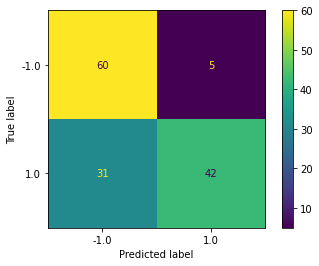

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true=Y_test, y_pred=clf_lr.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_lr.classes_)
disp.plot()


### 7.2 Precision, recall, and F1 score

In [80]:
print(classification_report(Y_test, clf_lr.predict(X_test)))

              precision    recall  f1-score   support

        -1.0       0.66      0.92      0.77        65
         1.0       0.89      0.58      0.70        73

    accuracy                           0.74       138
   macro avg       0.78      0.75      0.73       138
weighted avg       0.78      0.74      0.73       138



The confusion matrix indicates that there are more true positives and true negatives, which is a good indication, however, it is also predicting many false negatives (31). This means that the concern discussed above is valid. To fix this, there are a couple of techniques that can be employed: undersampling or oversampling. Since my training dataset is quite small, I've decided to attempt oversampling, rather than removing data (undersampling). This is explored in the next section.

## 8. Oversampling
### 8.1 SMOTE
In this section, I am using the Synthetic Minority Oversampling Technique (SMOTE) to balance the training data. SMOTE synthesizes new examples from the minority class (1.0 - supportive tweets). It does so by "selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line" [[reference]](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/). I use the `imblearn` python library to do this.


In [82]:
from imblearn.over_sampling import SMOTE

print(f"Before oversampling, counts of label '1': {sum(Y_train == 1)}")
print(f"Before oversampling, counts of label '-1': {sum(Y_train == -1)}")

smote = SMOTE(random_state = 123)
X_train_res, Y_train_res = smote.fit_resample(X_train, Y_train.ravel())

print(f"After oversampling, counts of label '1': {sum(Y_train_res == 1)}")
print(f"After oversampling, counts of label '-1': {sum(Y_train_res == -1)}")

Before oversampling, counts of label '1': 228
Before oversampling, counts of label '-1': 585
After oversampling, counts of label '1': 585
After oversampling, counts of label '-1': 585


### 8.2 Refitting & replotting 
Copied classifier fit codes from **Section 6**, but replacing `X_train` variable with the newly oversampled `X_train_res` (same for Y).

In [83]:
test_acc = []

# Logistic regression
clf_lr = LogisticRegression(C=1.0, penalty='l2', max_iter=1000, random_state=123)
clf_lr.fit(X_train_res, Y_train_res)

test_acc.append(accuracy_score(Y_test, clf_lr.predict(X_test)))

# SVM 
clf_svm = SVC(kernel='linear', C=0.1, random_state=123)
clf_svm.fit(X_train_res, Y_train_res)

test_acc.append(accuracy_score(Y_test, clf_svm.predict(X_test)))

# Random forest
clf_rf = RandomForestClassifier(n_estimators=300, min_samples_split=2, random_state=123)
clf_rf.fit(X_train_res, Y_train_res)

test_acc.append(accuracy_score(Y_test, clf_rf.predict(X_test)))

In [84]:
data = pd.DataFrame(
    {'Model': ['logistic reg.', 'svm', 'rand. forest'],
     'Accuracy': test_acc
    })
print(data)


alt.Chart(data).mark_bar(size=70).encode(
    alt.Y('Accuracy',
         scale=alt.Scale(domain=[0.6, 0.80])),
    x='Model:N',
    color='Model:N'
).properties(width=500, height=300)

           Model  Accuracy
0  logistic reg.  0.724638
1            svm  0.688406
2   rand. forest  0.695652


alt.Chart(...)

#### Observations
Test accuracies have decreased across the board, as would be expected, because it initially appeared to be good at predicting the majority class (-1), but was actually most likely only reporting  Also, after oversampling, the Random Forest classifier outperformed the SVM, but Logistic Regression remains the best, with a test accuracy of $0.724638$.

## 9. Secondary evaluation
After balancing the training dataset, I re-evaluated accuracies as well as the confusion matrix based on the highest performing classifier, logistic regression.
### 9.1 Confusion matrix
The confusion matrix below shows that the over-prediction of false negatives has been alleviated by the balancing of the training data. False positives have increased, but that may be due to the fact that features associated with positive tweets are lacking. While I was annotating, I noticed that positive tweets were mostly very short phrases. 

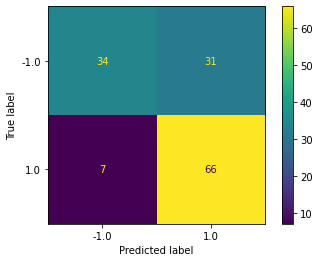

In [85]:
cm = confusion_matrix(y_true=Y_test, y_pred=clf_lr.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_lr.classes_)
disp.plot()

### 9.2 Baseline accuracy
With a balanced dataset, a baseline accuracy can be calculated based on assigning labels randomly. As this is a binary classification problem, random labeling would result in roughlt an accuracy of $0.50$. 

### 9.3 Precision, Recall, and F1 score
In the next code block I regenerate the evaluation report after refitting. 

In [86]:
print(classification_report(Y_test, clf_lr.predict(X_test)))

              precision    recall  f1-score   support

        -1.0       0.83      0.52      0.64        65
         1.0       0.68      0.90      0.78        73

    accuracy                           0.72       138
   macro avg       0.75      0.71      0.71       138
weighted avg       0.75      0.72      0.71       138



#### Observations
The accuracy reported for the logistic regression classifier (the highest performing one) is higher than the established baseline accuracy if the test were randomly labeled ($0.72 > 0.5$).

With regards to precision and recall, the following table displays precision and recall scores reported for the classifier before and after balancing the data.

|                  | Class | Precision | Recall | 
|------------------|-------|-----------|--------|
| Before balancing | -1.0  |    0.66   |  0.92  |
|                  |  1.0  |    0.89   |  0.58  |
| After balancing  | -1.0  |    0.83   |  0.52  |
|                  |  1.0  |    0.68   |  0.90  |

The precision score of class -1.0 increased after balancing the data. This means that the classifier is making less false positive predictions (i.e. predicting that the tweet was an 'opposing' tweet when it actually was not). This is a result of reducing bias towards the majority class when it was imbalanced. However, the precision score for class 1.0 went down after balancing. I attribute this to lack of good features that represent that class well.

Before balancing, the recall score of class 1.0 was fairly low (0.58), but increased after balancing to 0.9. This indicates that before balancing, the number of positives that were correctly predicted was low; i.e. there were many other positives that were predicted as -1.0. This is consistent with the majority class bias. After balancing, the bias reduced heavily, leading to a sharp rise in recall for class 1.0, which tells us that positives in class 1.0 are being misidentified a lot less. 


## Conclusion
There are a few areas of improvements as well as future extensions to this project. Firstly, a larger dataset is needed in order to obtain better features for NLP of supportive and opposing sentiments of female liberation. This is especially true for the supportive class (1.0), as there were a lot less features to extract from those tweets, whereas the opposing class (-1) had tweets that were much more verbose.

I also think this type of ML problem would benefit from a more sophisticated classification system, like adding a neutral label. The annotation guideline would differ depending on what angle I would be aiming for. For instance, many of the tweets referenced religion and culture, so one potential study could revolve around how likely it is for these themes to emerge in feminist calls for liberation on social media. 

I would also reattempt hyperparameter tuning of the chosen classifiers with the balanced dataset.

Finally, I believe this project can be extended further to gain insights on women's rights discourse in the middle east. At the beginning of this notebook, I'd retreived metadata that I didn't end up using for this part of the project, but can be included for future extensions. 